### Import data set (using sklearn for this)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False ,parser = "pandas"
)

X = X/ 255.0
y_enc = OneHotEncoder().fit_transform(y[:, np.newaxis]).toarray()

np.random.seed(42)
train_samples = 6000
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, train_size=train_samples, test_size=10000, random_state = 42
)
val_samples = 1000
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_samples, random_state = 42
)

 

In [3]:
len(y_val)

1000

Lets look at an example

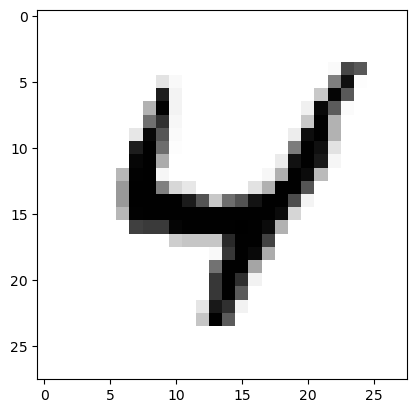

In [4]:
example = np.reshape(X_train[3],[28,28])
plt.imshow(example, cmap='Greys')

In [5]:
y_train[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

Define the activations

In [6]:
def relu(x):
    return (x > 0) * x         

def relu2deriv(output):
    return output>0            

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x/np.sum(e_x, axis = 1) 

In [7]:
import warnings
warnings.filterwarnings("error")

 This could be improved a lot (and more hypertuning could be done)
 
* better models!

But this serves for what I want to look at here

In [8]:

class SimpMNISTNet:
   def __init__(self, hidden_size):
      self.hidden_size = hidden_size
      self.weights_0_1 = 2*np.random.random((28*28,hidden_size)) - 1
      self.weights_1_2 = 2*np.random.random((hidden_size,10)) - 1
      self.bias_1 = np.zeros([1,hidden_size])
      self.bias_2 = np.zeros([1,10])

   def predict(self, X):
      layer_1 = relu(np.dot(X,self.weights_0_1) + self.bias_1)
      return softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
   
   def single_epoch_train(self, X, y, alpha, batch_size):
      eps = 10**-9
      indices = [*range(len(y))]
      np.random.shuffle(indices)
      batch_ind = [indices[i:i+batch_size] for i in range(0, len(indices), batch_size)]
      layer_2_error = 0
      for batch in batch_ind:
         layer_2_delta_b = np.zeros([1,10])
         layer_1_2_delta_w = np.zeros([self.hidden_size,10])
         layer_1_delta_b = np.zeros([1,self.hidden_size])
         layer_0_1_delta_w = np.zeros([28*28,self.hidden_size])
         for i in batch:
            layer_0 = X[i:i+1]
            layer_1 = relu(np.dot(layer_0,self.weights_0_1) + self.bias_1)
            layer_2 = softmax(np.dot(layer_1,self.weights_1_2) + self.bias_2)
            layer_2_error -= y[i:i+1].dot(np.log(layer_2 + eps).T)
            #layer_2_delta =  -y[i:i+1]*(1-layer_2)
            layer_2_delta =   layer_2 - y[i:i+1]
            layer_1_delta = layer_2_delta.dot(self.weights_1_2.T)*relu2deriv(layer_1)
            layer_1_delta_b += layer_1_delta
            layer_2_delta_b += layer_2_delta
            layer_1_2_delta_w += layer_1.T.dot(layer_2_delta)
            layer_0_1_delta_w += layer_0.T.dot(layer_1_delta)
         self.weights_1_2 -= alpha * layer_1_2_delta_w /len(batch)
         self.bias_2 -= alpha*layer_2_delta_b /len(batch)      
         self.weights_0_1 -= alpha * layer_0_1_delta_w /len(batch)
         self.bias_1 -= alpha*layer_1_delta_b / len(batch)
      return layer_2_error


   def sgd(self, X, y, X_val, y_val, alpha, batch_size, epochs):
      for iteration in range(epochs):
         error = self.single_epoch_train(X, y, alpha, batch_size)
         if((iteration + 1) % 10 ==0):
             print("Error:" + str(error) + " iter: " + str(iteration+1))
             corr = 0
             for i in range(len(y_val)):
                 corr += np.argmax(y_val[i]) == np.argmax(self.predict(X_val[i]))
             print("Val error:" + str(corr/len(y_val)))







In [142]:
alpha = 0.0003
np.random.seed(1)
model = SimpMNISTNet(100)
model.sgd(X_train, y_train, X_val, y_val, alpha, 50, 400)

Error:[[55158.40450503]] iter: 10
Val error:0.221
Error:[[41381.18853247]] iter: 20
Val error:0.341
Error:[[32001.62189283]] iter: 30
Val error:0.417
Error:[[26070.39206892]] iter: 40
Val error:0.487
Error:[[22217.22099443]] iter: 50
Val error:0.528
Error:[[19532.59701891]] iter: 60
Val error:0.567
Error:[[17538.69386708]] iter: 70
Val error:0.591
Error:[[16003.76349825]] iter: 80
Val error:0.616
Error:[[14772.7110725]] iter: 90
Val error:0.634
Error:[[13753.75868513]] iter: 100
Val error:0.649
Error:[[12894.50367047]] iter: 110
Val error:0.66
Error:[[12154.71337619]] iter: 120
Val error:0.673
Error:[[11512.65614865]] iter: 130
Val error:0.688
Error:[[10947.04404412]] iter: 140
Val error:0.696
Error:[[10447.71732924]] iter: 150
Val error:0.706
Error:[[10000.96422778]] iter: 160
Val error:0.713
Error:[[9597.8269667]] iter: 170
Val error:0.722
Error:[[9231.95332301]] iter: 180
Val error:0.729
Error:[[8900.84878588]] iter: 190
Val error:0.738
Error:[[8596.85489364]] iter: 200
Val error:0.

In [145]:
y_train[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [146]:
model.predict(X_train[3])

array([[1.15875013e-20, 2.48653391e-12, 2.47763172e-09, 5.27358644e-21,
        9.99999997e-01, 1.76712204e-20, 3.54693021e-13, 1.73550409e-14,
        1.79930558e-11, 2.86471472e-10]])

In [147]:
corr = 0
for i in range(len(y_test)):
    corr += np.argmax(y_test[i]) == np.argmax(model.predict(X_test[i]))

corr/len(y_test)

0.777

Thats not bad at all, I think one can do better though with more training examples and tuning

Look at weights. in the hidden layer each unit has 781 weights which can be seen as an 'image' that gets dotted with the test image to see if it correlates.  There is one of these 'images' for each hidden layer.  Which are important for figuring out that a digit is a 4?

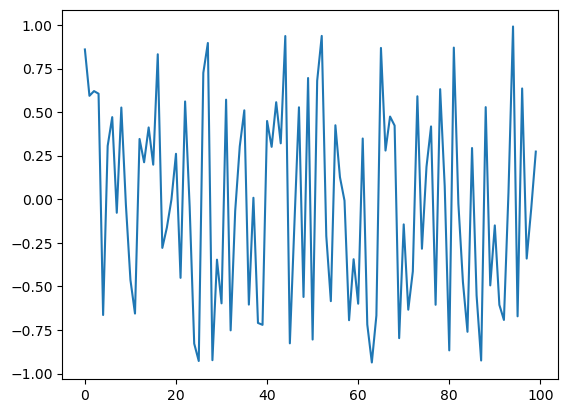

In [148]:
plt.plot(model.weights_1_2[:,4]) 

In [163]:
np.argsort(model.weights_1_2[:,4])[-20:]

array([42, 22, 31, 73,  1,  3,  2, 78, 96, 51, 49, 26, 16,  0, 65, 81, 27,
       44, 52, 94])

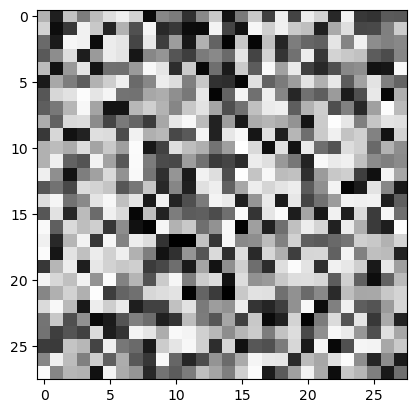

In [200]:
plt.imshow(np.reshape(model.weights_0_1[:,94],[28,28]),cmap='Greys')

Somehow this pattern correlates with part of a 4. I dont see it ;) Note that when i did this exercise with 300 hidden units i did see more digit like weights, but that was probably a symptom of overfitting!

Lets see what gets activated when it saw a 4

In [154]:
y_train[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

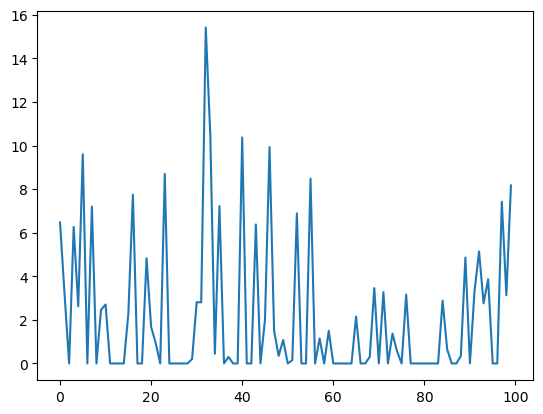

In [201]:
layer_1_test = relu(np.dot(X_train[3],model.weights_0_1) + model.bias_1)
plt.plot(layer_1_test[0])

In [164]:
np.argsort(layer_1_test[0])[-5:]

array([ 5, 46, 40, 33, 32])

the biggest layer hidden neuron that activates is #32 

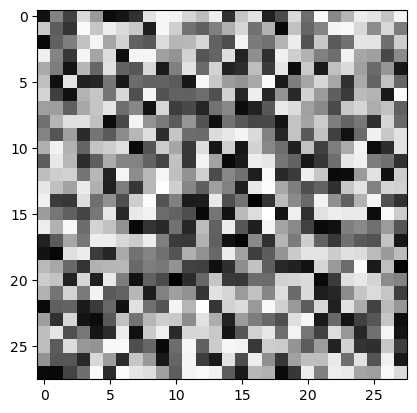

In [203]:
plt.imshow(np.reshape(model.weights_0_1[:,32],[28,28]),cmap='Greys')

Hmm.. . ok i was expecting to see something that would obvious correlate with a 4, but looking at the weight for this unit connecting to the output '4', it comes in with a minus sign.  So it is saying sort of that this particular digit has components that are NOT 4 like, but apparently other components beat this out.

In [166]:
model.weights_1_2[:,4][32]

-0.751943173758571

The biggest non-hib is 40

In [168]:
model.weights_1_2[:,4][40]

0.4489052512509414

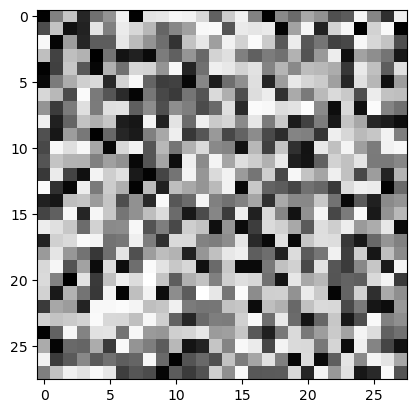

In [204]:
plt.imshow(np.reshape(model.weights_0_1[:,40],[28,28]), cmap = 'Greys')

So it is quite complicated.  The image of the 4 has high correlation with several of the weight vectors which activate several hidden layer units. This particular 4 correlates with non-4 components as well as '4 like' components. 

Let's take a look at one random test sample

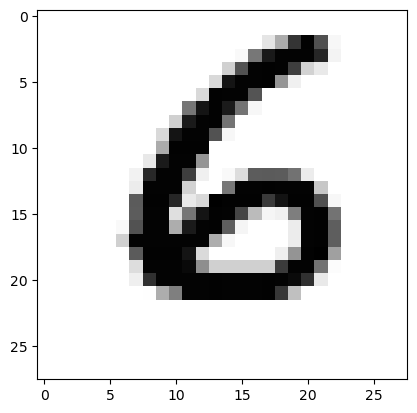

In [205]:
example2 = np.reshape(X_test[402],[28,28])
plt.imshow(example2, cmap = 'Greys')

In [178]:
np.argmax(model.predict(X_test[402]))

6

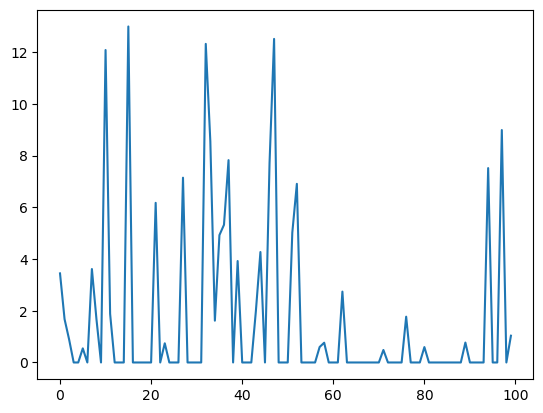

In [174]:
layer_1_test = relu(np.dot(X_test[402],model.weights_0_1) + model.bias_1)
plt.plot(layer_1_test[0])

In [182]:
top4= np.argsort(layer_1_test[0])[-4:]
top4

array([10, 32, 47, 15])

In [185]:
model.weights_1_2[:,6][top4]

array([0.84046099, 0.73655921, 0.90610809, 0.00807979])

Remember these are reversed.

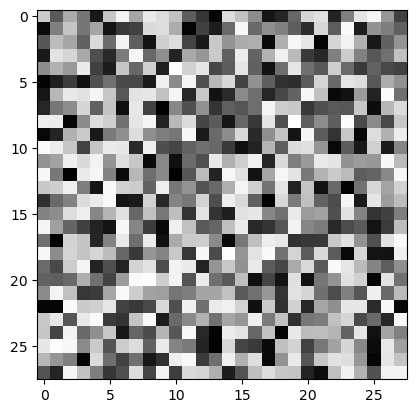

In [206]:
plt.imshow(np.reshape(model.weights_0_1[:,47],[28,28]), cmap='Greys')

I am going to put a pin in this for now.  I was hopping to see more of something 'six' shaped.

## SMaller hidden layer

In [216]:
alpha = 0.001
np.random.seed(1)
model10 = SimpMNISTNet(10)
model10.sgd(X_train, y_train, X_val, y_val, alpha, 50, 400)

Error:[[14799.33492116]] iter: 10
Val error:0.194
Error:[[11709.25294558]] iter: 20
Val error:0.237
Error:[[10698.92778871]] iter: 30
Val error:0.273
Error:[[10115.28619791]] iter: 40
Val error:0.294
Error:[[9669.62230761]] iter: 50
Val error:0.322
Error:[[9280.44082724]] iter: 60
Val error:0.349
Error:[[8914.89476825]] iter: 70
Val error:0.369
Error:[[8571.60400621]] iter: 80
Val error:0.387
Error:[[8274.51485981]] iter: 90
Val error:0.402
Error:[[8023.00668252]] iter: 100
Val error:0.416
Error:[[7809.42179237]] iter: 110
Val error:0.438
Error:[[7619.71940173]] iter: 120
Val error:0.462
Error:[[7448.62093522]] iter: 130
Val error:0.474
Error:[[7289.97002865]] iter: 140
Val error:0.487
Error:[[7140.0150361]] iter: 150
Val error:0.496
Error:[[6997.69785335]] iter: 160
Val error:0.506
Error:[[6864.33104123]] iter: 170
Val error:0.521
Error:[[6738.44640947]] iter: 180
Val error:0.531
Error:[[6620.39731297]] iter: 190
Val error:0.545
Error:[[6507.69134668]] iter: 200
Val error:0.556
Error:

In [217]:
corr = 0
for i in range(len(y_test)):
    corr += np.argmax(y_test[i]) == np.argmax(model10.predict(X_test[i]))

corr/len(y_test)

0.6474

In [218]:
np.argmax(model10.predict(X_test[402]))

6

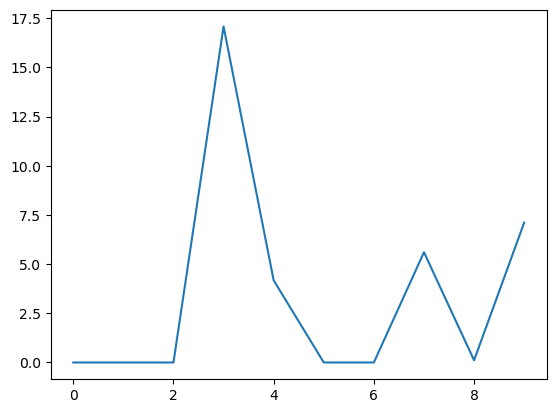

In [220]:
layer_1_test = relu(np.dot(X_test[402],model10.weights_0_1) + model10.bias_1)
plt.plot(layer_1_test[0])

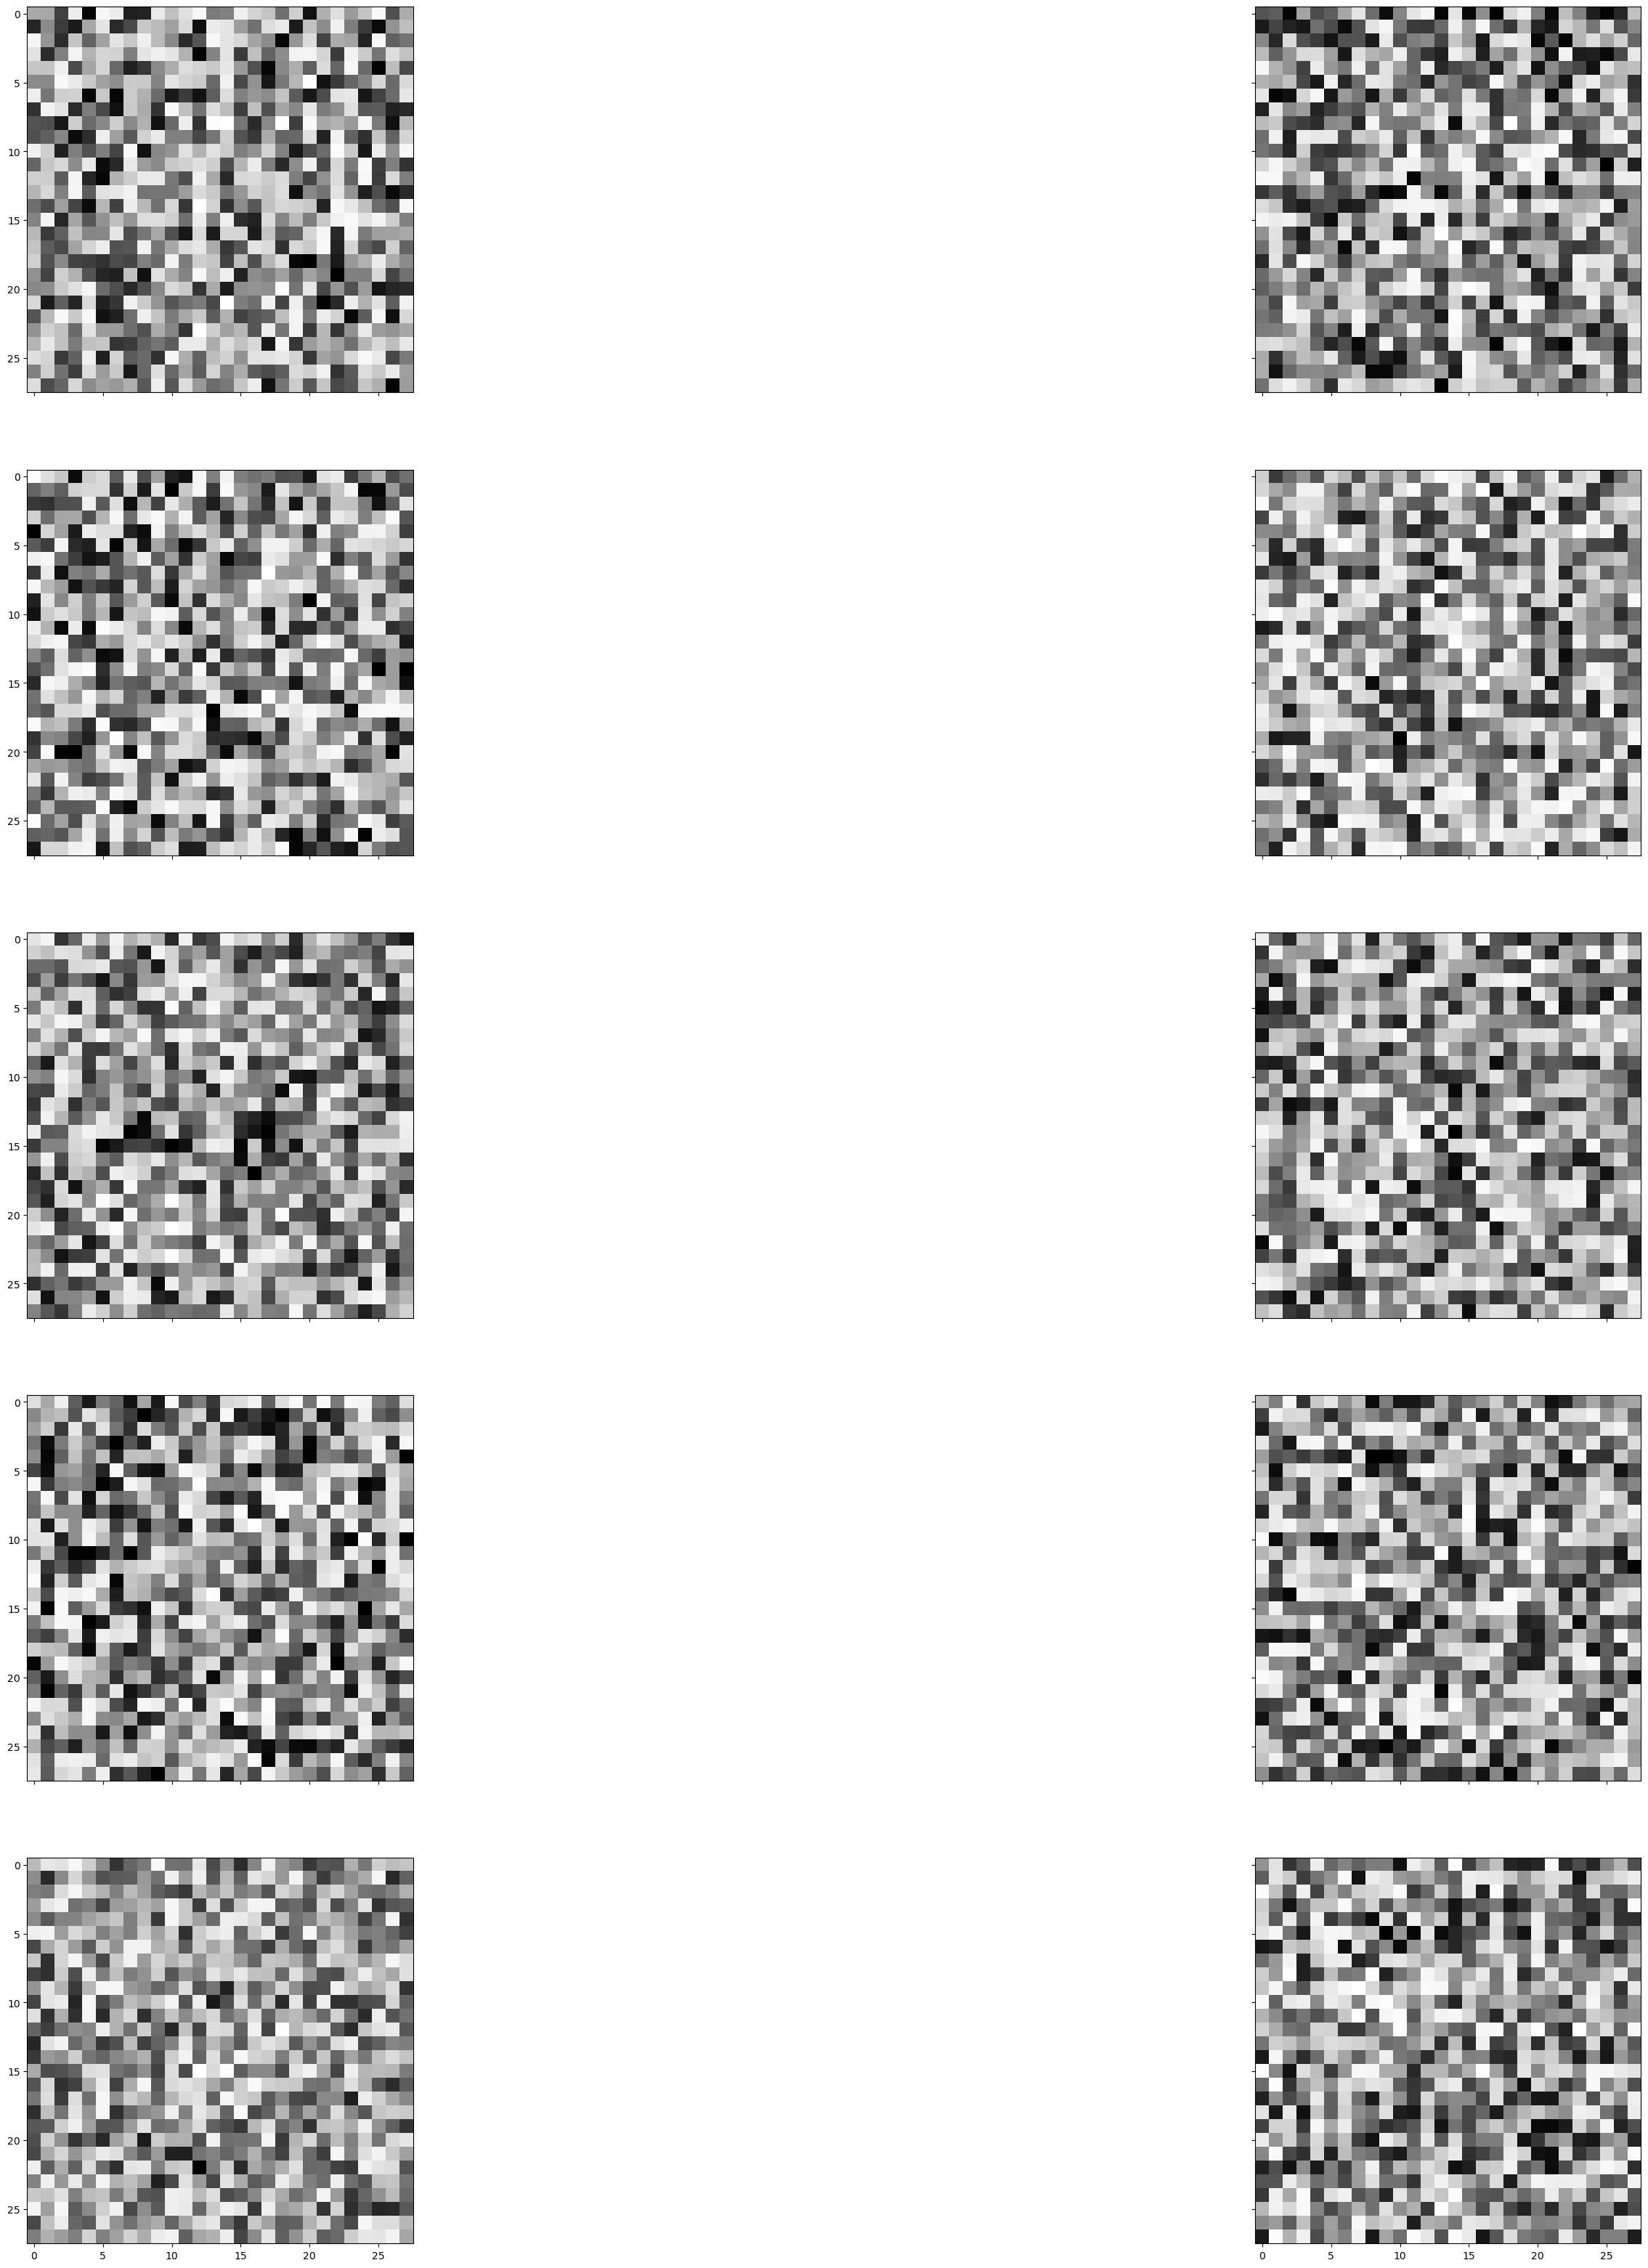

In [239]:
fig, axs = plt.subplots(5,2, 
                sharex = True, sharey=True, figsize =(40,40))
i=0
for  ax in axs.flat:
  ax.imshow(np.reshape(model10.weights_0_1[:,i],[28,28]), cmap='Greys')
  i = i+1


Maybe i should try NO hidden layer